In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
#Loading and Reading the Dataset

In [10]:
data = pd.read_csv("online_retail_II.csv")
print("-"*50)
print("Data import successfull")
data.head(3).style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

--------------------------------------------------
Data import successfull


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom


In [ ]:
#Exploring Information of the Dataset

In [11]:
pd.set_option('display.max_columns', None) 
def data_overview(df, head=5):
    print(" SHAPE OF DATASET ".center(125,'-'))
    print('Rows:{}'.format(df.shape[0]))
    print('Columns:{}'.format(df.shape[1]))
    print(" HEAD ".center(125,'-'))
    print(df.head(head))
    print("DATA TYPES".center(125,'-'))
    print(data.dtypes.value_counts())
    print(" MISSING VALUES ".center(125,'-'))
    print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))
    print(" DUPLICATED VALUES ".center(125,'-'))
    print(df.duplicated().sum())
    print(" STATISTICS OF DATA ".center(125,'-'))
    print(df.describe(include="all"))
    print("DATA INFO".center(125,'-'))
    print(df.info())
    
    
data_overview(data)

------------------------------------------------------ SHAPE OF DATASET -----------------------------------------------------
Rows:1067371
Columns:8
------------------------------------------------------------ HEAD -----------------------------------------------------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  

In [ ]:
#The Dataset has Rows: 1067371 and Columns:8
#The Dataset has 3 types of columns: strings(5), integer(1), float(2)
#The Dataset has Missing values in Customer ID (243007) and Description (4382)
#Invoice starts with the 'c' needs to be cleaned as it is cancelled transaction
#The Dataset has duplicates
#Aslo check for negative value and outliers in Quantity and Price

In [12]:
#Data Wrangling

In [13]:
print("Shape of data before removing NaN's CustomerID",data.shape)
data.dropna(subset="Customer ID",axis=0,inplace=True)
print("Shape of data after removing NaN's CustomerID",data.shape)

Shape of data before removing NaN's CustomerID (1067371, 8)
Shape of data after removing NaN's CustomerID (824364, 8)


In [14]:
print("Missing values in each column after cleaning customerID :\n",data.isnull().sum())

Missing values in each column after cleaning customerID :
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [15]:
#Removing cancelled products from invoice
data = data[~data.Invoice.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


In [16]:
#Removing Duplicates
print("Number of duplicates before cleaning:",data.duplicated().sum())
data = data.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",data.duplicated().sum())

Number of duplicates before cleaning: 26125
Number of duplicates after cleaning: 0


In [17]:
#Checking for negative value
print("Negative value in Quantity is:",(data.Quantity<0).sum())
print("Negative value in Price is:",(data.Price<0).sum())

Negative value in Quantity is: 0
Negative value in Price is: 0


In [18]:
#Cleaning Outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

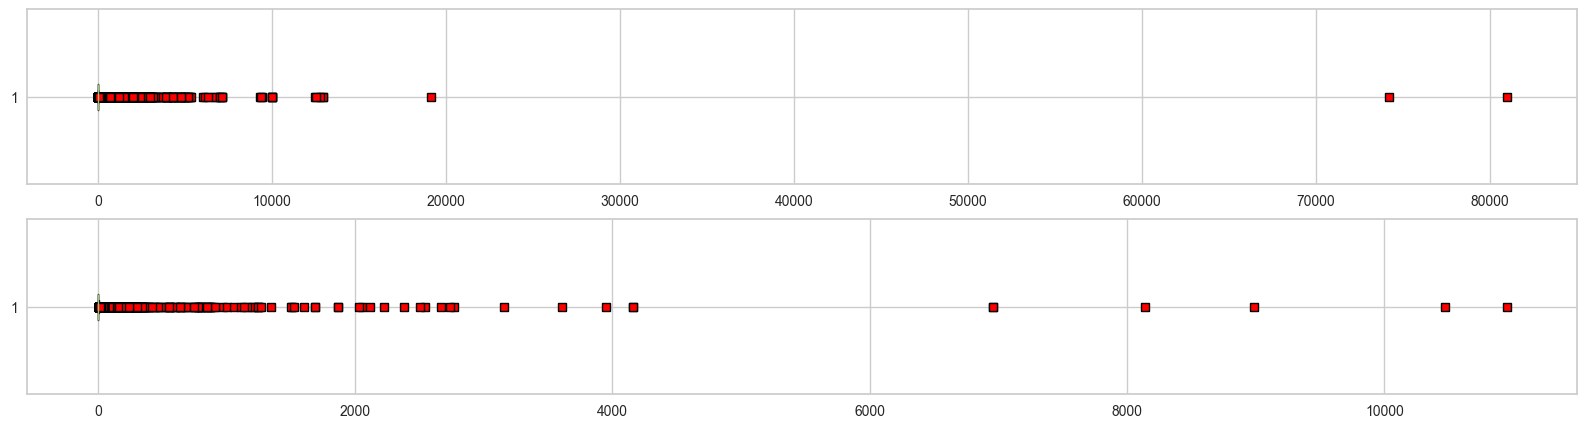

In [19]:
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Quantity","Price"]
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

In [20]:
# Applying the functions for remove the outlier.
replace_with_threshold(data, "Quantity")
replace_with_threshold(data, "Price")

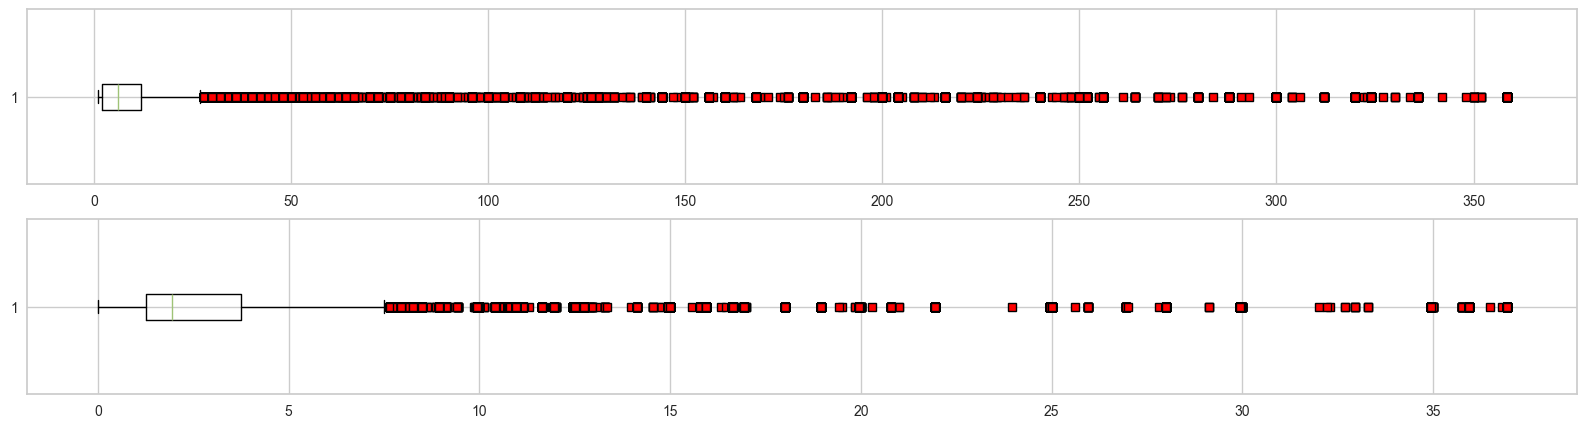

In [21]:
# Observing them after removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

In [22]:
#Feature Engineering

In [23]:
#Creating new feature Revenue
data["Revenue"] = data["Quantity"] * data["Price"]

In [24]:
#Creating Features for RFM Model
#Changing data type to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [25]:
print("Max date :",data["InvoiceDate"].max())
print("Min date :",data["InvoiceDate"].min())

Max date : 2011-12-09 12:50:00
Min date : 2009-12-01 07:45:00


In [26]:
#RFM Featuring

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09.
Latest_Date = dt.datetime(2011,12,10)

#Creating RFM features with subset of customerID
RFM = data.groupby('Customer ID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 
                                                 'Invoice': lambda x: x.nunique(), 
                                                 "Revenue": lambda x: x.sum()})
                                
RFM['InvoiceDate'] = RFM['InvoiceDate'].astype(int)

#Renaming column names to Recency, Frequency and Monetary
RFM.rename(columns={'InvoiceDate': 'Recency', 
                         'Invoice': 'Frequency', 
                         'Revenue': 'Monetary'}, inplace=True)

RFM.reset_index().head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Customer ID,Recency,Frequency,Monetary
0,12346.000000,325,12,745.700000
1,12347.000000,2,8,4921.530000
2,12348.000000,75,5,1991.860000
3,12349.000000,18,4,3786.500000
4,12350.000000,310,1,331.340000


In [27]:
RFM = RFM[(RFM["Frequency"]>1)]
RFM.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary
Customer ID,,,
12346.000000,325,12,745.700000
12347.000000,2,8,4921.530000
12348.000000,75,5,1991.860000
12349.000000,18,4,3786.500000
12352.000000,36,10,2098.940000


In [28]:
Shopping_Cycle = data.groupby('Customer ID').agg({'InvoiceDate': lambda x: ((x.max() - x.min()).days)})

In [29]:
RFM["Shopping_Cycle"] = Shopping_Cycle
RFM.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Shopping_Cycle
Customer ID,,,,
12346.000000,325,12,745.700000,400
12347.000000,2,8,4921.530000,402
12348.000000,75,5,1991.860000,362
12349.000000,18,4,3786.500000,570
12352.000000,36,10,2098.940000,356


In [30]:
RFM["Interpurchase_Time"] = RFM["Shopping_Cycle"] // RFM["Frequency"]
RFMT = RFM[["Recency","Frequency","Monetary","Interpurchase_Time"]]
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time
Customer ID,,,,
12346.000000,325,12,745.700000,33
12347.000000,2,8,4921.530000,50
12348.000000,75,5,1991.860000,72
12349.000000,18,4,3786.500000,142
12352.000000,36,10,2098.940000,35


In [31]:
#Modelling with KMeans Algorithm

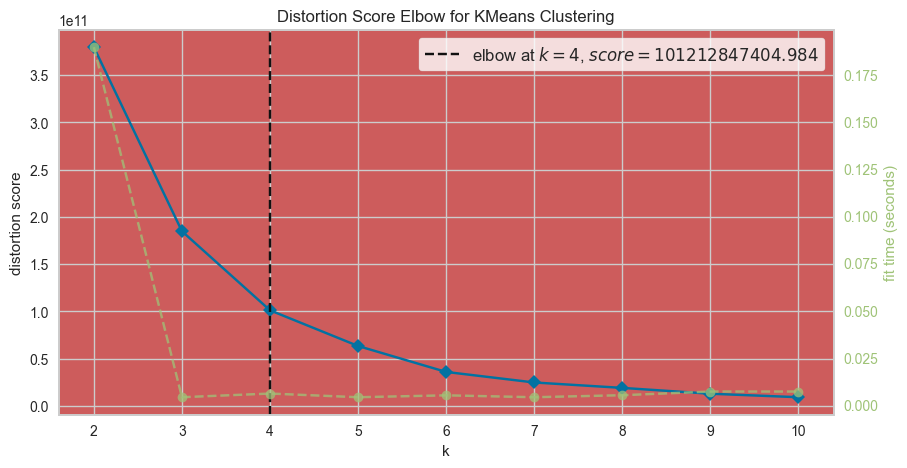

Therefore K = 4


In [32]:
# Finding initial K value using Elbow Method
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
Elbow_M = KElbowVisualizer(KMeans(), k=10) 
Elbow_M.fit(RFMT)
Elbow_M.show()
print("Therefore K = 4")

In [33]:
#Fitting KMeans Model
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(RFMT)

KMeans(max_iter=50, n_clusters=4)

In [34]:
RFMT["Clusters"]=kmeans.labels_
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time,Clusters
Customer ID,,,,,
12346.000000,325,12,745.700000,33,2
12347.000000,2,8,4921.530000,50,2
12348.000000,75,5,1991.860000,72,2
12349.000000,18,4,3786.500000,142,2
12352.000000,36,10,2098.940000,35,2


In [35]:
#Model : Evaluation

In [36]:
# how well the clusters are?:
#centriods
kmeans.cluster_centers_

array([[3.74927536e+01, 4.14202899e+01, 2.47420574e+04, 2.46304348e+01],
       [2.75000000e+00, 2.12750000e+02, 4.05626432e+05, 3.50000000e+00],
       [1.46298365e+02, 6.68138570e+00, 2.22340390e+03, 7.06699195e+01],
       [8.71428571e+00, 9.96428571e+01, 1.19519073e+05, 8.50000000e+00]])

<function matplotlib.pyplot.show(close=None, block=None)>

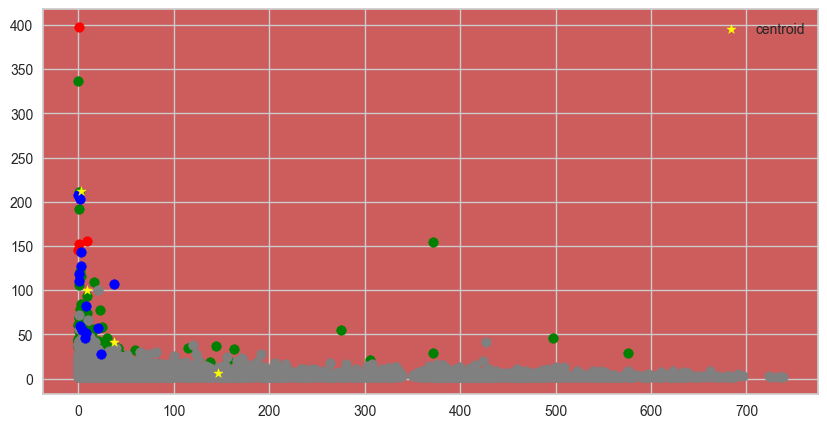

In [37]:
# grouping the data in accorandance with each cluster seperately
one = RFMT[RFMT["Clusters"]==0]
two = RFMT[RFMT["Clusters"]==1]
three = RFMT[RFMT["Clusters"]==2]
four = RFMT[RFMT["Clusters"]==3]

#Checking the quality of clustering in the data set
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
plt.scatter(one["Recency"],one["Frequency"],color='green')
plt.scatter(two["Recency"],two["Frequency"],color='red')
plt.scatter(three["Recency"],three["Frequency"],color='grey')
plt.scatter(four["Recency"],four["Frequency"],color='blue')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="yellow",marker="*",label="centroid")
plt.legend()
plt.show 